# Imports and settings

In [1]:
import numpy as np

from astropy.table import Table
from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord

import sys
import WD_models

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
%matplotlib tk

import scienceplots
plt.style.use('nature')

from IPython.display import Image

In [2]:
# Nature standards: https://www.nature.com/nature/for-authors/final-submission
figwidth_single = 89/25.4  # [inch]
figwidth_double = 183/25.4  # [inch]

# Read the candidate table

In [2]:
candidates = Table.read('../table_cut.fits')

In [4]:
# Take only high-probability cluster members with WD companions
idx = (candidates['m2'] < 1.4) & (candidates['probability'] > 0.9)

In [10]:
# Print some data
for i in np.where(idx)[0]:
    print(f"{i}) Gaia DR3 {candidates[i]['source_id']}: (ra,dec)=({candidates[i]['ra']} {candidates[i]['dec']}) \n\t Cluster ID #{candidates[i]['id']}, {10**candidates[i]['log_age_16']*1e-6:.0f}-{10**candidates[i]['log_age_84']*1e-6:.0f} Myr, membership probability {candidates[i]['probability']:.2f}")


0) Gaia DR3 5222629723121939328: (ra,dec)=(140.133199194747 -70.04783490924879) 
	 Cluster ID #23, 71-233 Myr, membership probability 1.00
1) Gaia DR3 3430973399654582528: (ra,dec)=(87.47872752091031 27.05892571824469) 
	 Cluster ID #311, 41-108 Myr, membership probability 1.00
2) Gaia DR3 5593547290691283584: (ra,dec)=(117.70948431791359 -35.09959549289103) 
	 Cluster ID #384, 194-450 Myr, membership probability 1.00
3) Gaia DR3 457836680469874560: (ra,dec)=(39.735040120038086 56.856809708649514) 
	 Cluster ID #588, 66-200 Myr, membership probability 1.00
4) Gaia DR3 5870538463339228416: (ra,dec)=(206.72766269227 -59.54597240466775) 
	 Cluster ID #606, 49-142 Myr, membership probability 1.00
5) Gaia DR3 2073689276577590912: (ra,dec)=(297.7405207097655 40.347878297960214) 
	 Cluster ID #619, 26-87 Myr, membership probability 1.00
6) Gaia DR3 4515889148041507968: (ra,dec)=(291.557051370994 20.019015412294024) 
	 Cluster ID #2141, 92-226 Myr, membership probability 1.00
7) Gaia DR3 20036

# WD temperature

In [3]:
model = WD_models.load_model(low_mass_model='Bedard2020',
                             middle_mass_model='Bedard2020',
                             high_mass_model='ONe',
                             atm_type='H')

m_agecool_to_logteff = WD_models.interp_xy_z_func(x=model['mass_array'],
                                                  y=model['age_cool'],
                                                  z=model['logteff'],
                                                  interp_type='linear')

In [46]:
candidates['wd_teff_age84'] = 10**m_agecool_to_logteff(candidates['m2'], 10**candidates['log_age_84']*1e-9)
candidates['wd_teff_age50'] = 10**m_agecool_to_logteff(candidates['m2'], 10**candidates['log_age_50']*1e-9)

# Calculate WD magnitude

## FUV

In [11]:
model = WD_models.load_model(low_mass_model='Bedard2020',
                             middle_mass_model='Bedard2020',
                             high_mass_model='ONe',
                             atm_type='H',
                             HR_bands=('FUV-NUV', 'FUV'))

In [ ]:
filename = f'./FUV'

t = np.arange(0, 1, 0.01)

fig, ax = plt.subplots(figsize=(figwidth_single, 0.6*figwidth_single))

idx = np.array([40])

for m2, parallax in zip(candidates['AMRF_m2'][idx], candidates['parallax'][idx]):
    ax.plot(t, model['m_agecool_to_Mag'](m2, t) + 5*np.log10(1000/parallax)-5, label=f'{m2:.2f} M$_\odot$@{1000/parallax:.0f}pc')
ax.invert_yaxis()
ax.set_xlabel('Cooling age (Gyr)')
ax.set_ylabel('FUV')
ax.set_title("WD expected apparent magnitude")
ax.legend()
plt.show()

# fig.savefig(filename + ".png", dpi=300, bbox_inches="tight")
# Image(filename+".png")

In [8]:
col_fuv = np.full(len(candidates),np.nan)

for i in range(len(candidates)):
    m2 = candidates['parsec_m2'][i]
    if np.ma.is_masked(m2):
        m2 = candidates['parsec_m2_*'][i]
    if m2 < 1.4:
        parallax = candidates['parallax'][i]
        t = candidates['log_age_50'][i]
        col_fuv[i] = np.round(model['m_agecool_to_Mag'](m2, 10**t*1e-9) + 5*np.log10(1000/parallax)-5,2)

# for m2, parallax, t in zip(candidates['AMRF_m2'][idx], candidates['parallax'][idx],candidates['log_age_50'][idx]):
#     print(np.round(model['m_agecool_to_Mag'](m2, 10**t*1e-9) + 5*np.log10(1000/parallax)-5,2))

## NUV

In [4]:
model = WD_models.load_model(low_mass_model='Bedard2020',
                             middle_mass_model='Bedard2020',
                             high_mass_model='ONe',
                             atm_type='H',
                             HR_bands=('FUV-NUV', 'NUV'))

In [6]:
i = 40
# nums = []
# for id in idx:
#     if(id): nums.append(i)
#     i += 1

In [7]:
galex_nuv = (19.30 + 19.44)/2
nuv_ext = 0.974
param_nuv = galex_nuv - nuv_ext
param_age = 0.43

In [32]:
model['m_agecool_to_Mag'](m2, 1.15) + 5*np.log10(1000/parallax)-5

21.104224237470085

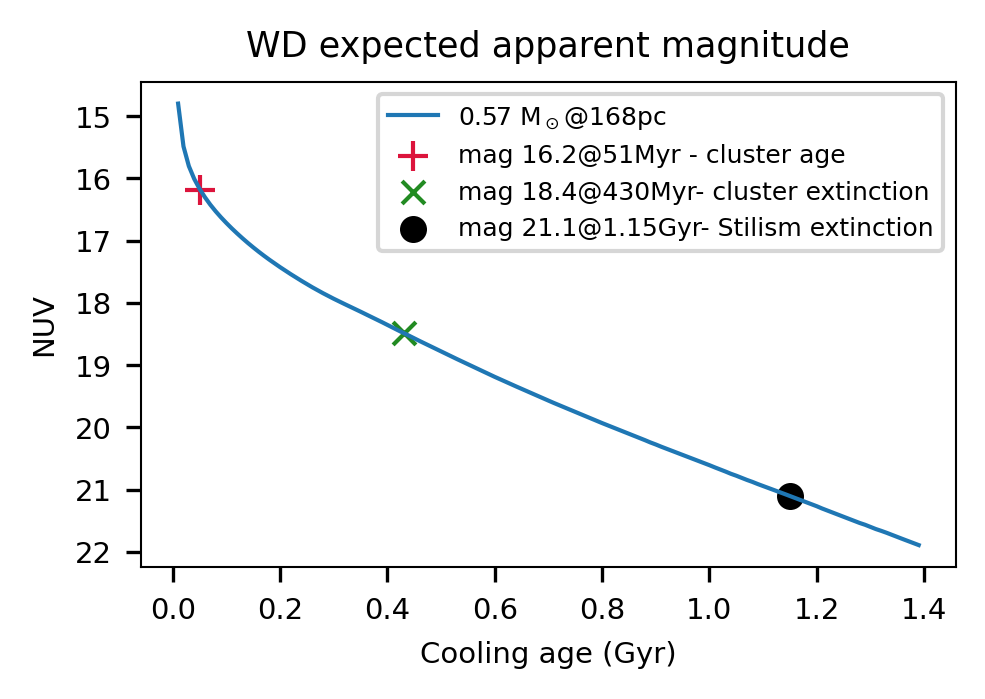

In [35]:
t = np.arange(0, 1.4, 0.01)
# m2 = candidates['parsec_m2'][40]
m2 = 0.57
parallax = candidates['parallax'][40]
age = 10**candidates['log_age_50'][40]*1e-9
mag = model['m_agecool_to_Mag'](m2, age) + 5*np.log10(1000/parallax)-5

filename = f'./exp_NUV_{1}'
fig, ax = plt.subplots(figsize=(figwidth_single, 0.6*figwidth_single))
ax.plot(t, model['m_agecool_to_Mag'](m2, t) + 5*np.log10(1000/parallax)-5, label=f'{m2:.2f} M$_\odot$@{1000/parallax:.0f}pc')
ax.scatter(age,model['m_agecool_to_Mag'](m2, age) + 5*np.log10(1000/parallax)-5, label=f'mag {mag:.1f}@{1000*age:.0f}Myr - cluster age',c='Crimson',marker='+',s=50)
ax.scatter(param_age,model['m_agecool_to_Mag'](m2, param_age) + 5*np.log10(1000/parallax)-5, label=f'mag {param_nuv:.1f}@{1000*param_age:.0f}Myr- cluster extinction',c='ForestGreen',marker='x',s=30)
ax.scatter(1.15,model['m_agecool_to_Mag'](m2, 1.15) + 5*np.log10(1000/parallax)-5, label=f'mag {21.1:.1f}@{1.15:.2f}Gyr- Stilism extinction',c='k',marker='o',s=30)
ax.invert_yaxis()
ax.set_xlabel('Cooling age (Gyr)')
ax.set_ylabel('NUV')
ax.set_title("WD expected apparent magnitude")
ax.legend(fontsize=6)
fig.savefig(filename + ".png", dpi=300, bbox_inches="tight")
Image(filename+".png")

In [12]:
age1 = 10**candidates['log_age_16'][40]*1e-9
mag1 = model['m_agecool_to_Mag'](m2 + 0.04, age1) + 5*np.log10(1000/parallax)-5

age2 = 10**candidates['log_age_84'][40]*1e-9
mag2 = model['m_agecool_to_Mag'](m2 - 0.04, age2) + 5*np.log10(1000/parallax)-5

print(mag1)
print(mag)
print(mag2)

15.61275787907234
16.14962912182466
16.90859747686119


In [8]:
t = np.arange(0, 1, 0.01)


for m2, parallax, num in zip(candidates['parsec_m2'][idx], candidates['parallax'][idx],nums):
    filename = f'exp_NUV_{num}'
    fig, ax = plt.subplots(figsize=(figwidth_single, 0.6*figwidth_single))
    ax.plot(t, model['m_agecool_to_Mag'](m2, t) + 5*np.log10(1000/parallax)-5, label=f'{m2:.2f} M$_\odot$@{1000/parallax:.0f}pc')
    ax.invert_yaxis()
    ax.set_xlabel('Cooling age (Gyr)')
    ax.set_ylabel('NUV')
    ax.set_title("WD expected apparent magnitude")
    ax.legend()
    # fig.savefig(filename + ".png", dpi=300, bbox_inches="tight")
    # Image(filename+".png")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15176\3114004079.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(figwidth_single, 0.6*figwidth_single))


In [13]:
col_nuv = np.full(len(candidates),np.nan)

for i in range(len(candidates)):
    m2 = candidates['parsec_m2'][i]
    if np.ma.is_masked(m2):
        m2 = candidates['parsec_m2_*'][i]
    if m2 < 1.4:
        parallax = candidates['parallax'][i]
        t = candidates['log_age_50'][i]
        col_nuv[i] = np.round(model['m_agecool_to_Mag'](m2, 10**t*1e-9) + 5*np.log10(1000/parallax)-5,2)


# for m2, parallax, t in zip(candidates['AMRF_m2'][idx], candidates['parallax'][idx],candidates['log_age_50'][idx]):
#     print(np.round(model['m_agecool_to_Mag'](m2, 10**t*1e-9) + 5*np.log10(1000/parallax)-5,2))

## SSDS u-band

In [18]:
model = WD_models.load_model(low_mass_model='Bedard2020',
                             middle_mass_model='Bedard2020',
                             high_mass_model='ONe',
                             atm_type='H',
                             HR_bands=('Su-Sg', 'Su'))

In [19]:
col_sdss_u = np.full(len(candidates),np.nan)

for i in range(len(candidates)):
    m2 = candidates['parsec_m2'][i]
    if np.ma.is_masked(m2):
        m2 = candidates['parsec_m2_*'][i]
    if m2 < 1.4:
        parallax = candidates['parallax'][i]
        t = candidates['log_age_50'][i]
        col_sdss_u[i] = np.round(model['m_agecool_to_Mag'](m2, 10**t*1e-9) + 5*np.log10(1000/parallax)-5,2)

# for m2, parallax, t in zip(candidates['AMRF_m2'][idx], candidates['parallax'][idx],candidates['log_age_50'][idx]):
#     print(np.round(model['m_agecool_to_Mag'](m2, 10**t*1e-9) + 5*np.log10(1000/parallax)-5,2))

In [ ]:
# filename = f'./FUV'

t = np.arange(0, 1, 0.01)

fig, ax = plt.subplots(figsize=(figwidth_single, 0.6*figwidth_single))

idx = np.array([11])

for m2, parallax in zip(candidates['AMRF_m2'][idx], candidates['parallax'][idx]):
    ax.plot(t, model['m_agecool_to_Mag'](m2, t) + 5*np.log10(1000/parallax)-5, label=f'{m2:.2f} M$_\odot$@{1000/parallax:.0f}pc')
ax.invert_yaxis()
ax.set_xlabel('Cooling age (Gyr)')
ax.set_ylabel('SSDS u')
ax.set_title("WD expected apparent magnitude")
ax.legend()
plt.show()

# fig.savefig(filename + ".png", dpi=300, bbox_inches="tight")
# Image(filename+".png")

## SSDS g-band

In [23]:
model = WD_models.load_model(low_mass_model='Bedard2020',
                             middle_mass_model='Bedard2020',
                             high_mass_model='ONe',
                             atm_type='H',
                             HR_bands=('Su-Sg', 'Sg'))

In [24]:
col_sdss_g = np.full(len(candidates),np.nan)

for i in range(len(candidates)):
    m2 = candidates['parsec_m2'][i]
    if np.ma.is_masked(m2):
        m2 = candidates['parsec_m2_*'][i]
    if m2 < 1.4:
        parallax = candidates['parallax'][i]
        t = candidates['log_age_50'][i]
        col_sdss_g[i] = np.round(model['m_agecool_to_Mag'](m2, 10**t*1e-9) + 5*np.log10(1000/parallax)-5,2)

# for m2, parallax, t in zip(candidates['AMRF_m2'][idx], candidates['parallax'][idx],candidates['log_age_50'][idx]):
#     print(np.round(model['m_agecool_to_Mag'](m2, 10**t*1e-9) + 5*np.log10(1000/parallax)-5,2))

In [ ]:

t = np.arange(0, 1, 0.01)

fig, ax = plt.subplots(figsize=(figwidth_single, 0.6*figwidth_single))

idx = np.array([11])

for m2, parallax in zip(candidates['AMRF_m2'][idx], candidates['parallax'][idx]):
    ax.plot(t, model['m_agecool_to_Mag'](m2, t) + 5*np.log10(1000/parallax)-5, label=f'{m2:.2f} M$_\odot$@{1000/parallax:.0f}pc')
ax.invert_yaxis()
ax.set_xlabel('Cooling age (Gyr)')
ax.set_ylabel('SSDS u')
ax.set_title("WD expected apparent magnitude")
ax.legend()
plt.show()
